In [1]:
from scipy.fftpack import fft, dct, idct, ifft, rfft, irfft
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features as spc
import thermocepstrum as tc
from scipy.signal import periodogram
#from scipy import fft
# import scipy._realtransforms as rfft
# from scipy import ifft
# from scipy.signal.windows import triang
from scipy.interpolate import interp1d as interpol
# from scipy.special import lambertw, gamma
# from scipy import fft.dct, fft.idct
#import scipy.fft.dct 


In [2]:
a = 1.0e12
def hz2mel(hz):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
#     return a * np.log(1+hz/a)/np.log(2)
    return a / np.log(2) * np.log(1 + np.log(1+hz/a)/np.log(2))


def mel2hz(mel):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
#     return a*(np.exp(np.log(2)*mel/(a))-1)
    return a * (np.exp(np.log(2) * (np.exp(mel*np.log(2)/a) - 1)) - 1)

def hz2mel_rec(hz, n=1):
    """Convert a value in Hertz to Mels

    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(hz)
    for i in range(n):
        x = a * np.log(1+x/a)/np.log(2)
    return x 


def mel2hz_rec(mel, n=1):
    """Convert a value in Mels to Hertz

    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    x = np.copy(mel)
    for i in range(n):
        x = a*(np.exp(np.log(2)*x/(a))-1)
    return x

def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    #print('melpoints=',melpoints)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bins = np.floor(2*nfft*mel2hz(melpoints)/samplerate)
    
    fbank = np.zeros([nfilt, nfft])
    for j in range(0,nfilt):
        
        for i in range(int(bins[j]), int(bins[j+1])):
            fbank[j,i] = (i - bins[j]) / (bins[j+1]-bins[j])
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fbank[j,i] = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
        fbank[j,:] *= 2./(bins[j+2]-bins[j])    
    return fbank, melpoints

def mel_filter(arr, nfilt=20, samplerate=16000, lowfreq=0, highfreq=None, axis=0, nrec=1):
    
    dim = list(arr.shape)
    dim[axis] = nfilt+2
#     dim[axis] = nfilt
    
    out = np.zeros(tuple(dim)) #, dtype = np.complex)
    
    
    
    highfreq= highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel_rec(lowfreq, nrec)
    highmel = hz2mel_rec(highfreq, nrec)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    print('melpoints', melpoints)
    nfft = arr.shape[axis]
    print('mel2hz={}'.format(mel2hz_rec(melpoints, nrec)))
    bins = np.floor(2*nfft*mel2hz_rec(melpoints, nrec)/samplerate)
    print('bins=',bins)
    for j in range(0, nfilt):
        for i in range(int(bins[j]), int(bins[j+1])):
            fb = (i - bins[j]) / (bins[j+1]-bins[j])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
        for i in range(int(bins[j+1]), int(bins[j+2])):
            fb = (bins[j+2]-i) / (bins[j+2]-bins[j+1])
#             out[j] += fb*(1+1j)*arr[i]
            out[j+1] += fb*arr[i]
            
#         out[j] *= 2./(bins[j+2]-bins[j])
        out[j+1] *= 2./(bins[j+2]-bins[j])
    out[0] = arr[0]              
    out[-1] = arr[int(bins[-1])] 

    return out, melpoints

# def to_filter(flux):
def _gamma_inverse(x):
    """
    Inverse the gamma function.
    http://mathoverflow.net/questions/12828/inverse-gamma-function
    """
    k=1.461632 # the positive zero of the digamma function, scipy.special.psi
#     assert x>=k, 'gamma(x) is strictly increasing for x >= k, k=%1.2f, x=%1.2f' % (k, x)
    C=np.sqrt(2*np.pi)/np.e - gamma(k) # approximately 0.036534
    L=np.log((x+C)/np.sqrt(2*np.pi))
    gamma_inv = 0.5+L/lambertw(L/np.e)
    return gamma_inv

In [3]:
data=tc.i_o.read_lammps_log.LAMMPSLogFile(\
                                          'data/log.10.lammps',
                                         run_keyword="FLUX PRODUCTION RUN")
d=data.read_datalines(select_ckeys=['flux', 'Jel', 'Temp'])
vol = 59343.164 # Ang^3

  run_keyword found at line 13372.
  column headers found at line 13384. Reading data...
 #####################################
  all_ckeys =  {'Step': array([0]), 'Time': array([1]), 'Temp': array([2]), 'Press': array([3]), 'flux': array([4, 5, 6]), 'Jel': array([7, 8, 9])}
 #####################################
  ckey =  {'flux': array([4, 5, 6]), 'Jel': array([7, 8, 9]), 'Temp': array([2])}
    step =    100000 -  49.99% completed
    step =    200000 -  99.98% completed
  endrun_keyword found.
  Retaining an even number of steps (even_NSTEPS=True).
  ( 200000 ) steps read.
DONE.  Elapsed time:  2.591275930404663 seconds


In [4]:
d['flux'].shape

(200000, 3)

In [106]:
j = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=800)
jlog = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=500,mel_log_flag=True)

Using multicomponent code.
Using multicomponent code.


Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =     100.00000 THz
 Sampling time         TSKIP =             1 steps
                             =         5.000 fs
 Original  n. of frequencies =        100001
 Resampled n. of frequencies =        100001
 PSD      @cutoff  (pre-filter) =    183.53572
                  (post-filter) =    183.53572
 log(PSD) @cutoff  (pre-filter) =      5.21064
                  (post-filter) =      5.21064
 min(PSD)          (pre-filter) =      1.14775
 min(PSD)         (post-filter) =      1.14775
 % of original PSD Power f<f* (pre-filter)  = 100.000000
-----------------------------------------------------



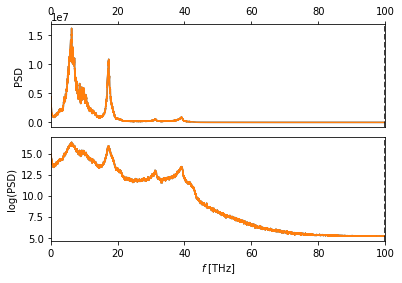

In [6]:
jf=j.resample_current(PSD_FILTER_W=0.1, fstar_THz=100)

In [7]:
np.sqrt(0.000001)

0.001

In [107]:
j.mel_cepstral_analysis(debug=True)
j.cepstral_analysis()
print('log mel-filter')
# jlog.mel_cepstral_analysis()

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 36  (P* = 37, corr_factor = 1.000000)
  L_0*   =          14.887260 +/-   0.070688
  S_0*   =     3827118.104781 +/- 270531.889641
-----------------------------------------------------
  Mel kappa* =           6.794043 +/-   0.480258  W/mK
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 176  (P* = 177, corr_factor = 1.000000)
  L_0*   =          14.300872 +/-   0.047714
  S_0*   =     2893819.803599 +/- 138075.459135
-----------------------------------------------------
  kappa* =           5.137217 +/-   0.245117  W/mK
-----------------------------------------------------

log mel-filter


In [9]:
0.242439 / 14.887260 
270531.889641 / 3827118.104781

0.07068814764379494

In [11]:
print(j.mel_psd_std[:5])
print(j.mel_psd_std_einsum[:5])
print(j.dct.tau_std_Kmin,j.kappa_scale)
138075.459135 * j.kappa_scale *0.5

[270531.88964083 275202.91431548 278307.64741279 279868.30754168
 279941.55259345]
[0.07068815 0.07196875 0.07296289 0.07367708 0.07412278]
138075.4591354817 3.5504749469394664e-06


0.24511672922299083

In [46]:
conv_cc=ifft(fft(j.covxi , axis = 1),axis=0)
conv_cc1=fft(ifft(j.covxi , axis = 0),axis=1)
print(conv_cc)
conv_cc[j.dct.aic_Kmin + 1:,:] = 0.
conv_cc[:,j.dct.aic_Kmin + 1:] = 0.
print(np.diag(ifft(fft(conv_cc , axis = 0),axis=1).real))
print(np.diag(ifft(fft(conv_cc1 , axis = 0),axis=1).real)[:6])


[[0.02556893+3.97991421e-19j 0.00995579-1.14797410e-02j
  0.00437377-7.78625829e-03j ... 0.00286917+5.55140351e-03j
  0.00437377+7.78625829e-03j 0.00995579+1.14797410e-02j]
 [0.00995579+1.14797410e-02j 0.02556856-1.73039748e-20j
  0.00995553-1.14793874e-02j ... 0.00228912+4.26047535e-03j
  0.0028692 +5.55157501e-03j 0.00437381+7.78637833e-03j]
 [0.00437377+7.78625829e-03j 0.00995553+1.14793874e-02j
  0.02556745+8.30590791e-19j ... 0.00200971+3.43809797e-03j
  0.00228913+4.26054132e-03j 0.0028692 +5.55157501e-03j]
 ...
 [0.00286917-5.55140351e-03j 0.00228912-4.26047535e-03j
  0.00200971-3.43809797e-03j ... 0.02556561+1.66118158e-18j
  0.00995502-1.14786803e-02j 0.00437364-7.78589816e-03j]
 [0.00437377-7.78625829e-03j 0.0028692 -5.55157501e-03j
  0.00228913-4.26054132e-03j ... 0.00995502+1.14786803e-02j
  0.02556745-8.99806691e-19j 0.00995553-1.14793874e-02j]
 [0.00995579-1.14797410e-02j 0.00437381-7.78637833e-03j
  0.0028692 -5.55157501e-03j ... 0.00437364+7.78589816e-03j
  0.00995553+1

<IPython.core.display.Javascript object>


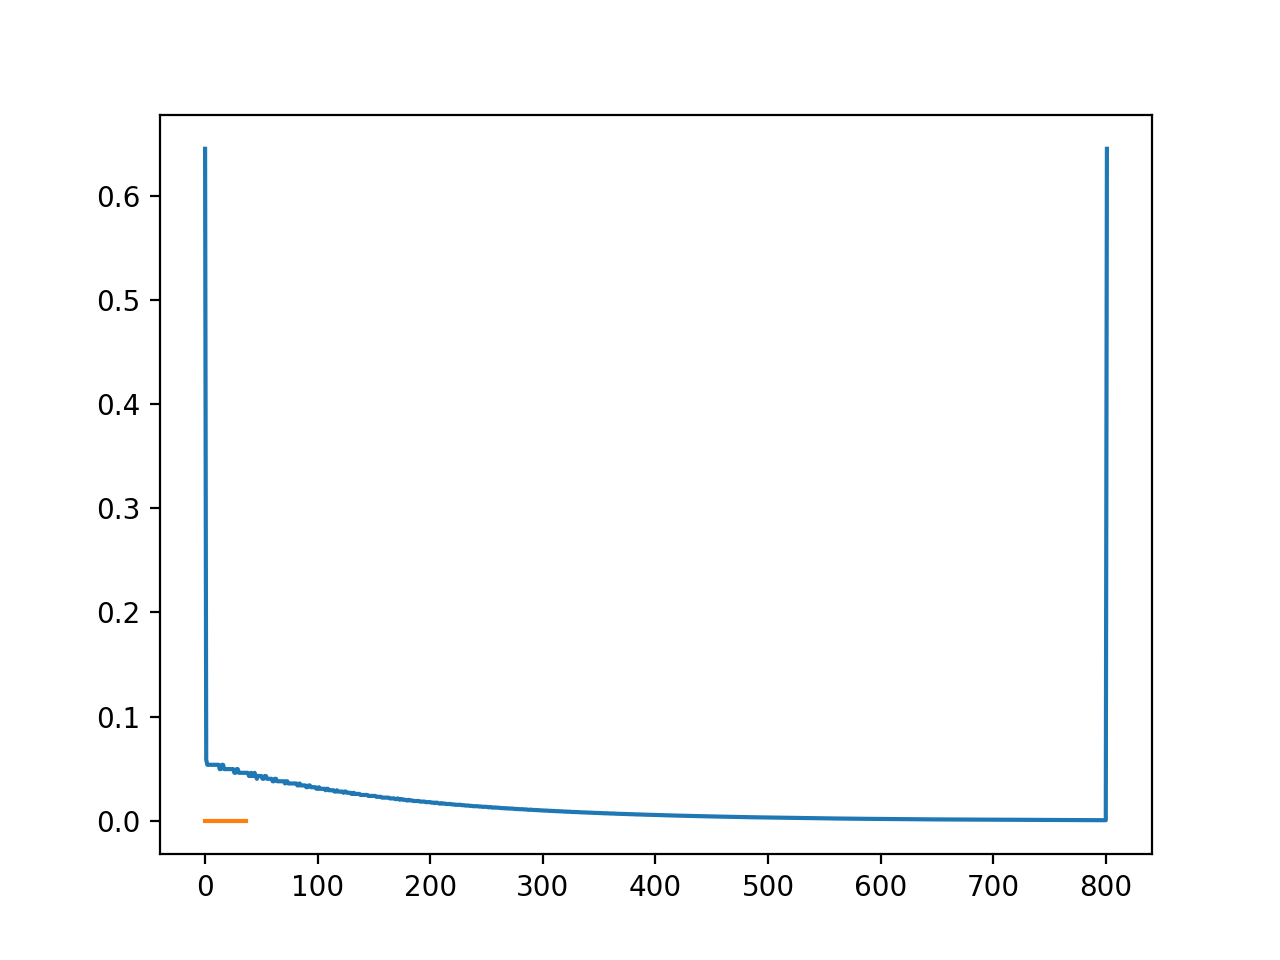

In [13]:
%matplotlib notebook

plt.plot(np.diag(j.covxi))

In [14]:
j.mel_psd_std*j.kappa_scale/2.

array([1.25488249e-07, 1.27761623e-07, 1.29526457e-07, 1.30794321e-07,
       1.31585538e-07, 1.31928826e-07, 1.31860769e-07, 1.31425072e-07,
       1.30671612e-07, 1.29655255e-07, 1.28434421e-07, 1.27069424e-07,
       1.25620594e-07, 1.24146230e-07, 1.22700482e-07, 1.21331270e-07,
       1.20078406e-07, 1.18972074e-07, 1.18031844e-07, 1.17266330e-07,
       1.16673566e-07, 1.16242052e-07, 1.15952389e-07, 1.15779310e-07,
       1.15693921e-07, 1.15665940e-07, 1.15665773e-07, 1.15666275e-07,
       1.15644146e-07, 1.15580907e-07, 1.15463457e-07, 1.15284256e-07,
       1.15041142e-07, 1.14736869e-07, 1.14378388e-07, 1.13975950e-07,
       1.13542083e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

<IPython.core.display.Javascript object>


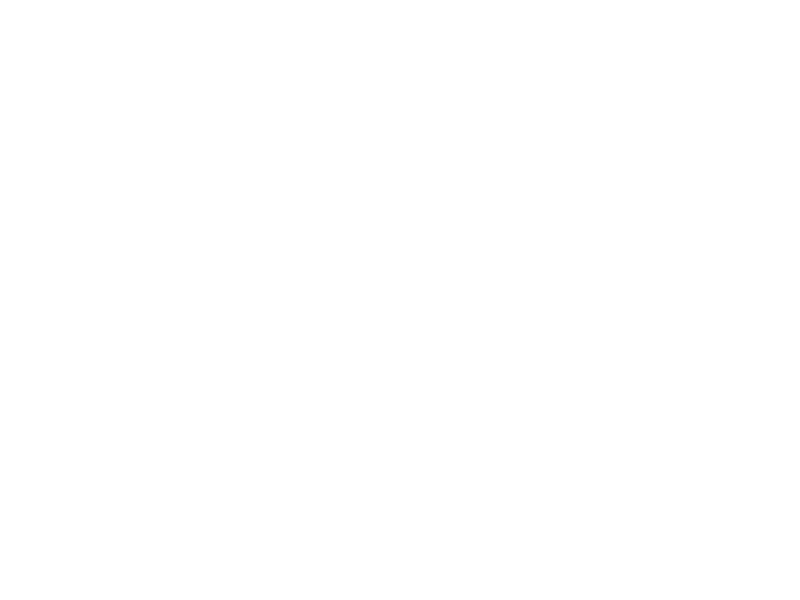

In [22]:
%matplotlib notebook
plt.plot(j.mel_psd_std*j.kappa_scale/2.)

In [11]:
# jr=j.resample_current(fstar_THz=1.0)[0]
j.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 176  (P* = 177, corr_factor = 1.000000)
  L_0*   =          14.300872 +/-   0.047714
  S_0*   =     2893819.803590 +/- 138075.459135
-----------------------------------------------------
  kappa* =           5.137217 +/-   0.245117  W/mK
-----------------------------------------------------



<IPython.core.display.Javascript object>


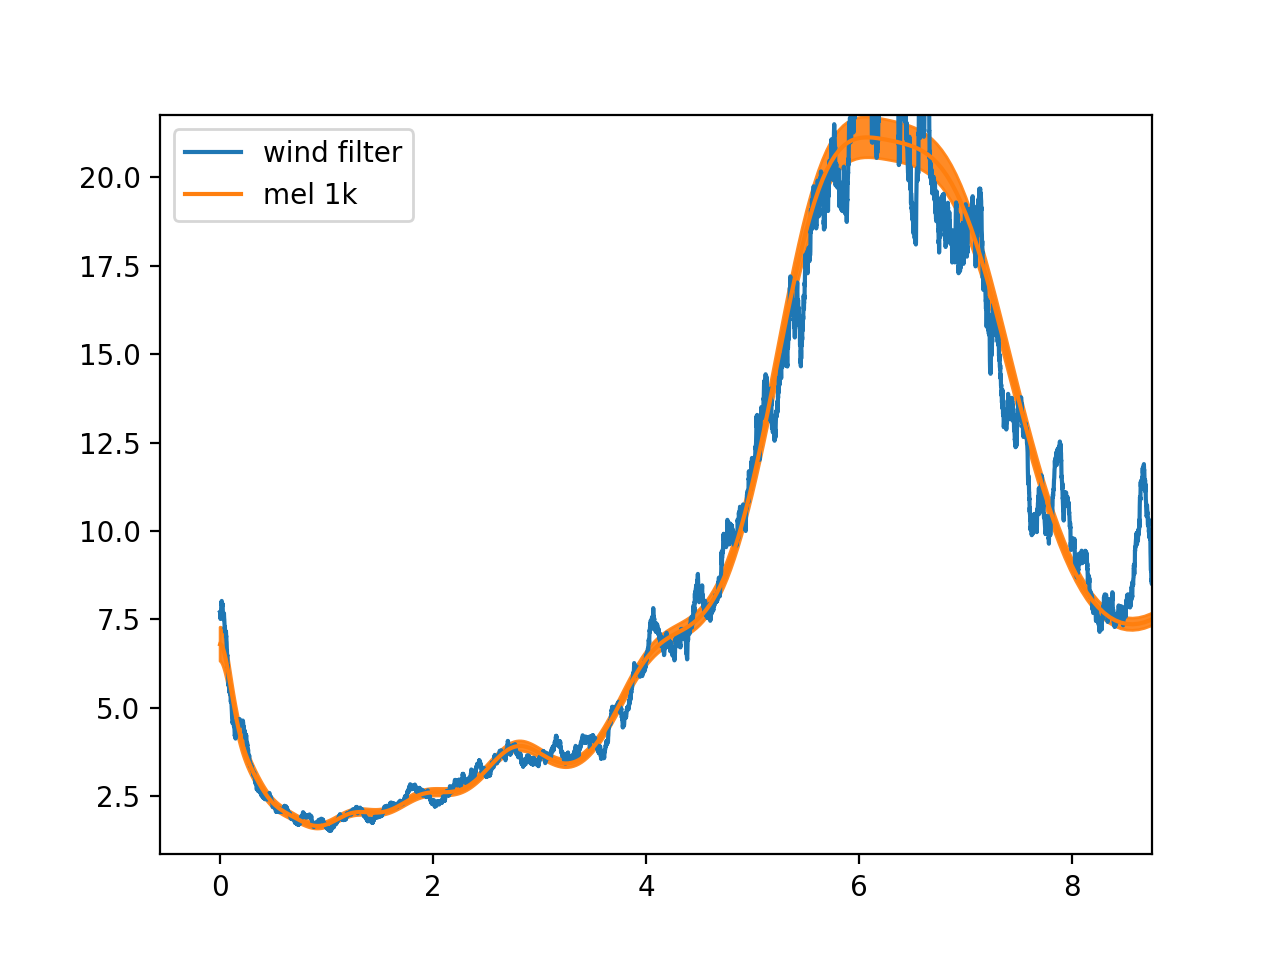

In [14]:
%matplotlib notebook
conv=j.kappa_scale/2
#plt.plot(j.freqs_THz, j.psd*conv, label='no filter', alpha=0.3)
plt.plot(jf[0].freqs_THz, jf[0].fpsd*conv, label='wind filter')

cesrterr = j.mel_psd_std*conv
#plt.plot(j.freqs_THz, j.dct.psd*conv, label='cepstrum')
p=plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_dct.psd, label='mel 1k')
plt.fill_between(j.mel_filtered_freqs_THz, conv*j.mel_dct.psd-cesrterr , conv*j.mel_dct.psd+cesrterr,alpha=0.9,color=p[0].get_color())
#plt.plot(j.mel_filtered_freqs_THz, conv*j.mel_filtered_psd, label='psd mel 1k',alpha=0.6)
#plt.plot(jlog.mel_filtered_freqs_THz, conv*jlog.mel_dct.psd, label='logmel 1k')
#plt.plot(jlog.mel2hz_rec(jlog.mel_points,jlog.mel_nrecursion)*1e-12, conv*np.exp(jlog.mel_filtered),'o-', label='logmel points')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j10k.mel_dct.psd, label='mel 10k')
#plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*j50k.mel_dct.psd, label='mel 50k')


# plt.plot(j.mel_filtered_freqs_THz*1e-24, conv*jpsd_sq, label='sq')

#plt.plot(jnewfull.freqs_THz,jnewfull.psd*conv, label='media a blocchi') #,marker=marker,ms=ms,lw=lw)
#plt.plot(jnewfull.freqs_THz,jnewfull.dct.psd*conv, label='media a blocchi cepstral') #,marker=marker,ms=ms,lw=lw)


plt.legend()

<IPython.core.display.Javascript object>


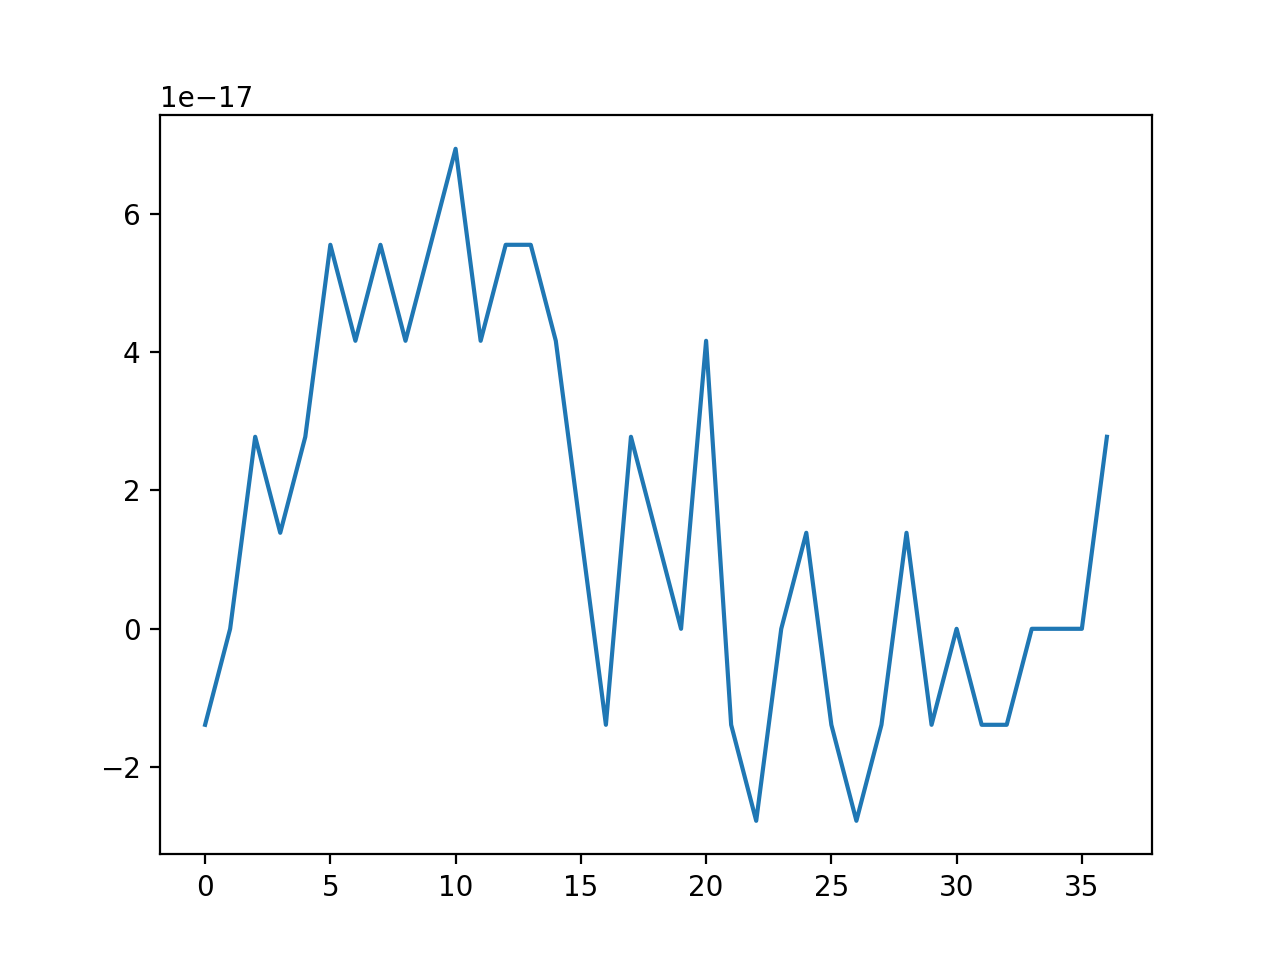

In [12]:
%matplotlib notebook
plt.plot(j.mel_psd_std[:37]/j.mel_dct.psd[:37]- j.mel_psd_std_einsum[:37])
#j.mel_psd_std

# $\kappa$ as function of nfilter 

In [61]:
jjs = {} # dictionary -> nfilter: j.HeatCurrent
NFILTERS = np.arange(100,6000,100)
print('NFILTERS = ',NFILTERS)
kappa = np.zeros((NFILTERS.shape[0],2))
for jfilt in np.arange(NFILTERS.shape[0]):
    filt = NFILTERS[jfilt]
    jjs[filt] = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=filt)
    jjs[filt].mel_cepstral_analysis()
    kappa[jfilt,0] = jjs[filt].mel_kappa_Kmin
    kappa[jfilt,1] = jjs[filt].mel_kappa_Kmin_std
    

NFILTERS =  [ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800
 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200
 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600
 5700 5800 5900]
Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 15  (P* = 16, corr_factor = 1.000000)
  L_0*   =          14.637239 +/-   0.176633
  S_0*   =     2980501.396116 +/- 526455.852676
-----------------------------------------------------
  Mel kappa* =           5.291098 +/-   0.934584  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 17  (P* = 18, corr_factor = 1.000000)
  L_0*  

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 38  (P* = 39, corr_factor = 1.000000)
  L_0*   =          14.979432 +/-   0.056009
  S_0*   =     4196640.621490 +/- 235050.480983
-----------------------------------------------------
  Mel kappa* =           7.450034 +/-   0.417270  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 38  (P* = 39, corr_factor = 1.000000)
  L_0*   =          14.973706 +/-   0.055495
  S_0*   =     4172678.668469 +/- 231562.143919
-----------------------------------------------------
  Mel kappa* =           7.407496 +/-   0.411078  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPS

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 49  (P* = 50, corr_factor = 1.000000)
  L_0*   =          15.031117 +/-   0.061311
  S_0*   =     4419246.170063 +/- 270947.553120
-----------------------------------------------------
  Mel kappa* =           7.845211 +/-   0.480996  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 49  (P* = 50, corr_factor = 1.000000)
  L_0*   =          15.029447 +/-   0.061203
  S_0*   =     4411871.497369 +/- 270019.207441
-----------------------------------------------------
  Mel kappa* =           7.832120 +/-   0.479348  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPS

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 50  (P* = 51, corr_factor = 1.000000)
  L_0*   =          15.092330 +/-   0.062861
  S_0*   =     4698212.683187 +/- 295334.830717
-----------------------------------------------------
  Mel kappa* =           8.340443 +/-   0.524289  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 49  (P* = 50, corr_factor = 1.000000)
  L_0*   =          14.986293 +/-   0.062569
  S_0*   =     4225532.208831 +/- 264385.458945
-----------------------------------------------------
  Mel kappa* =           7.501323 +/-   0.469347  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPS

In [87]:

jjs
NFILTERS = np.arange(100,11000,100)
print('NFILTERS = ',NFILTERS)
print(NFILTERS[np.where(NFILTERS==6000)[0][0]:])
for filt in NFILTERS[np.where(NFILTERS==6000)[0][0]:]:
    jjs[filt] = tc.HeatCurrent(j=[d['flux'], d['Jel']], DT_FS=5.0, TEMPERATURE=np.mean(d['Temp']),
                   units='metal', VOLUME=vol, do_mel=True, mel_nrecursion=1, mel_nfilt=filt)
    jjs[filt].mel_cepstral_analysis()


NFILTERS =  [  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700 10800
 10900]
[ 6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900]
Using multicompon

-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 52  (P* = 53, corr_factor = 1.000000)
  L_0*   =          15.026546 +/-   0.064690
  S_0*   =     4399091.423152 +/- 284578.150841
-----------------------------------------------------
  Mel kappa* =           7.809432 +/-   0.505194  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 52  (P* = 53, corr_factor = 1.000000)
  L_0*   =          15.036720 +/-   0.064428
  S_0*   =     4444075.541276 +/- 286321.826538
-----------------------------------------------------
  Mel kappa* =           7.889289 +/-   0.508289  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPS

//anaconda3/envs/tcmel/lib/python3.7/site-packages/thermocepstrum/md/mdsample.py:468: RuntimeWarning: invalid value encountered in double_scalars
  out[j+1] = np.sum(arr[int(bins[j]):int(bins[j+2])], axis=axis)/(bins[j+2]-bins[j])
//anaconda3/envs/tcmel/lib/python3.7/site-packages/thermocepstrum/md/cepstral.py:51: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/Nbins
//anaconda3/envs/tcmel/lib/python3.7/site-packages/thermocepstrum/md/cepstral.py:57: RuntimeWarning: invalid value encountered in multiply
  var_diag = Nbins * T**2 * trigamma
//anaconda3/envs/tcmel/lib/python3.7/site-packages/thermocepstrum/md/cepstral.py:64: RuntimeWarning: invalid value encountered in multiply
  psd_THEORY_mean = (polygamma(0, N_COMPONENTS) - np.log(N_COMPONENTS)) * Nbins * T


-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 0  (P* = 1, corr_factor = 1.000000)
  L_0*   =                nan +/-        nan
  S_0*   =                nan +/-        nan
-----------------------------------------------------
  Mel kappa* =                nan +/-        nan  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 0  (P* = 1, corr_factor = 1.000000)
  L_0*   =                nan +/-        nan
  S_0*   =                nan +/-        nan
-----------------------------------------------------
  Mel kappa* =                nan +/-        nan  W/mK
-----------------------------------------------------

Using multicomponent code.
-----------------------------------------------------
  MEL CEPSTRAL ANALY

//anaconda3/envs/tcmel/lib/python3.7/site-packages/thermocepstrum/md/cepstral.py:59: RuntimeWarning: invalid value encountered in multiply
  var_sdiag [1:-2]=(bins[3:-1] - bins[2:-2])*T[1:-3]*T[2:-2]*trigamma


KeyboardInterrupt: 

In [90]:
jjs[10000].mel_bins

KeyError: 10000

In [91]:
Pstar = np.zeros(NFILTERS.shape[0])
kappa = np.zeros((NFILTERS.shape[0],2))
for jfilt in np.arange(NFILTERS.shape[0]):
    filt=NFILTERS[jfilt]
    Pstar[jfilt] = jjs[filt].mel_dct.aic_Kmin + 1
    kappa[jfilt,0] = jjs[filt].mel_kappa_Kmin
    kappa[jfilt,1] = jjs[filt].mel_kappa_Kmin_std

AttributeError: 'HeatCurrent' object has no attribute 'mel_kappa_Kmin'

<IPython.core.display.Javascript object>


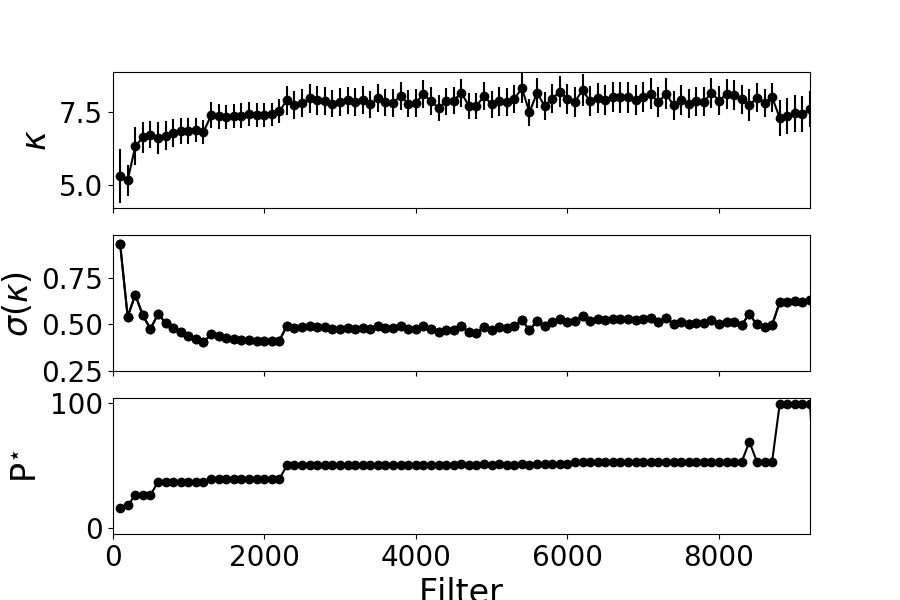

(0.25, 0.981313365688124)

In [105]:
%matplotlib notebook

ls=24
fig, ax = plt.subplots(3,figsize=(9,6) ,sharex=True)
conv=j.kappa_scale/2
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
ax[2].tick_params(labelsize=20)
#plt.plot(j.freqs_THz, j.psd*conv, label='no filter', alpha=0.3)

ax[0].set_ylabel(r'$\kappa$ ',size=ls)
ax[1].set_ylabel(r'$\sigma(\kappa)$ ',size=ls)
ax[2].set_xlabel('Filter',size=ls)
ax[2].set_ylabel(r'P$^{\star}$',size=ls)

ax[0].errorbar(NFILTERS[:], kappa[:,0],kappa[:,1], marker='o',label='wind filter',c='black')
ax[1].plot(NFILTERS, kappa[:,1], marker='o',label='wind filter',c='black')
ax[1].plot(NFILTERS, kappa[:,1], marker='o',label='wind filter',c='black')
ax[2].plot(NFILTERS, Pstar, marker='o',label='wind filter',c='black')

ax[0].set_xlim(0,9200)
ax[0].set_ylim(4.2,8.9)
ax[1].set_ylim(0.25)

## Prove FFT

In [13]:
covxi = np.random.normal(size=(10,10))
covxi = covxi + covxi.T
for i in range(len(covxi)):
    covxi[i,i] = covxi[i,i]**2

In [30]:
covxi[0]

array([ 1.18498189e+01, -1.08693999e+00, -1.18234631e-01, -3.67300296e-01,
        7.43854604e-03, -8.17742782e-01, -1.84723249e+00,  8.46017361e-01,
       -3.98129285e-01,  5.68846951e-01])

In [34]:
irfft(rfft(covxi, axis = 1), axis = 0)

array([[  5.28218045,   3.72044044,  -0.13195927,  -1.4529916 ,
         -1.55673154,  -0.11714915,  -2.5816563 ,  -0.56051506,
         -3.39732923,   1.10498473],
       [ -3.63241446,   1.89250474,  -6.15427239,   5.84325628,
         -6.49393655,   4.25911506,   2.47828528,  -1.50570898,
          5.15370585,  -4.80763151],
       [  9.93061302,   4.13819685,  10.28965929,  -5.95984158,
          2.01169487,  -5.08043047,  -3.46378546,   5.18636113,
         -7.54902944,   4.97533477],
       [-12.32641457,  -3.52258707,  -5.80066858,  10.54638873,
         -1.65033466,   7.50916763,   4.0336596 ,  -0.67500635,
          8.88771886,  -4.82336222],
       [  5.97622188,  -0.76901621,   3.70969449,  -0.79742415,
          6.02436953,  -1.71750387,  -3.06246027,   3.07055434,
         -0.75764012,   9.72540594],
       [  2.11257277,   1.54708297,   1.35186574,   0.46265666,
          1.34360273,   1.47695638,   2.54253596,   1.81824602,
          1.37997884,   3.32531481],
       [ -

In [41]:
tmp = ifft(fft(covxi, axis=1), axis=0)
tmp[4:, 4:] = 0.0
np.diag(ifft(fft(tmp, axis=1), axis=0).real)

array([ 5.56217122, -4.23205998, 28.68980229, -3.4367203 , -0.86784575,
       -1.26689124,  4.7767631 ,  0.98767477, -0.79032497,  5.71036322])

In [10]:
f=fft(np.random.normal(size=100))

<IPython.core.display.Javascript object>


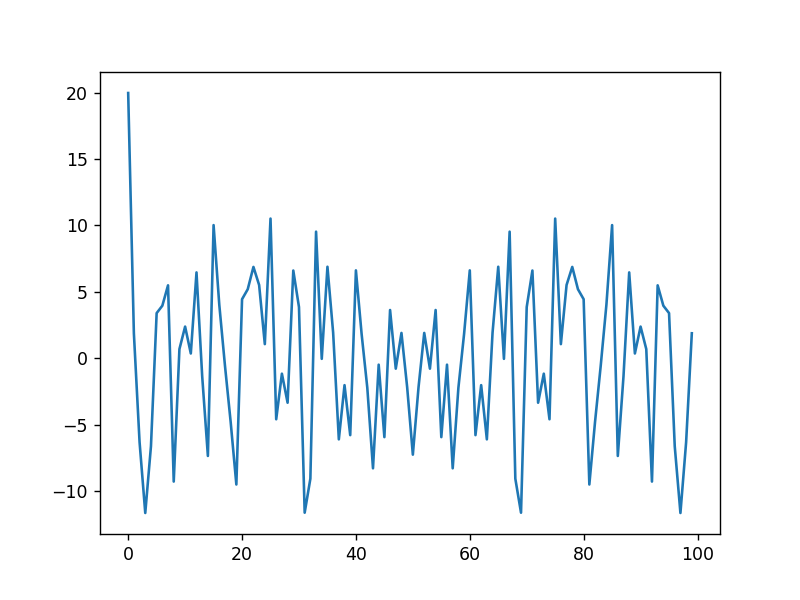

In [13]:
%matplotlib notebook
plt.plot(f.real)

In [14]:
covxi

NameError: name 'covxi' is not defined

In [27]:
n1,n2=covxi.shape
fc = np.zeros(covxi.shape, dtype = np.complex)
fcc = np.zeros(covxi.shape, dtype = np.complex)

for m in range(n2):
    fc[:, m] = np.sum(covxi * np.exp(2*np.pi*1j*m*np.arange(n2)/n2), axis=1)
for n in range(n1):
    fc[n, :] = np.mean(fc * np.exp(-2*np.pi*1j*n*np.arange(n1)/n1), axis=0)
fc[4:, 4:] = 0.0   
for j in range(n2):
    fcc[:, j] = np.sum(fc * np.exp(2*np.pi*1j*j*np.arange(n2)/n2), axis=1)
for j in range(n1):
    fcc[j, :] = np.mean(fcc * np.exp(-2*np.pi*1j*j*np.arange(n1)/n1), axis=0)
    

In [45]:
r1 = np.arange(n1)
r2 = np.arange(n2)
rs1 = np.arange(n1)
rs1[4:] = 0
rs2 = np.arange(n2)
rs2[4:] = 0

eps = np.exp(2*np.pi*1j*np.outer(r1, rs2)/n1)
ems = np.exp(-2*np.pi*1j*np.outer(r1, rs2)/n1)
ep  = np.exp(2*np.pi*1j*np.outer(r1, r2)/n1)
em  = np.exp(-2*np.pi*1j*np.outer(r1, r2)/n1)

In [43]:
rs1

array([0, 1, 2, 3, 0, 0, 0, 0, 0, 0])

In [51]:
cacca=np.einsum('am,bn,jn,mi,ji->ab', eps, ems, ep, em, covxi)

In [53]:
np.diag(cacca).real

array([ 13.86518275,  20.96480727,   8.19217098,  24.58919425,
        17.17074262, -11.27099686,  86.39999693, 228.78051832,
       187.71495494,  50.27952523])